In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

RANDOM_SEED = 42

In [3]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise=0.03, random_state=RANDOM_SEED)

In [4]:
import pandas as pd

moons = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    'labels': y
})

moons.head(10)

,X1,X2,labels
0,-0.009332,0.390981,1
1,0.954574,-0.473756,1
2,0.918526,-0.425196,1
3,0.412768,-0.376385,1
4,-0.845320,0.528799,0
5,0.579542,-0.352979,1
6,0.294884,-0.209238,1
7,-0.014488,0.435896,1
8,1.626510,-0.281207,1
9,0.671598,0.786422,0


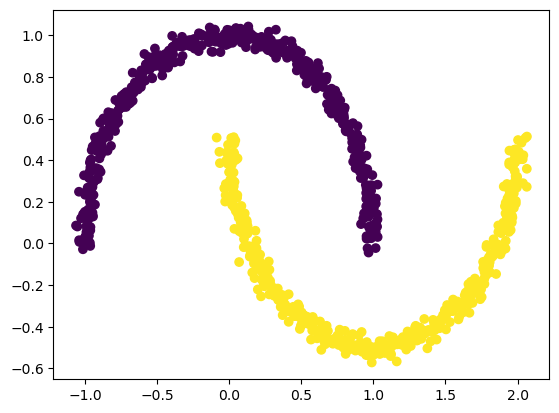

In [5]:
import matplotlib.pyplot as plt

plt.scatter(x = X[:, 0], y=X[:, 1], c=y)

In [6]:
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [17]:
import torch 
from torch import nn

class MoonModelV0(nn.Module):
    def __init__(self, input_dim = 2, output_dim = 1, hidden_units = 10):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_dim),
        )
    
    def forward(self, x):
        y = self.linear_relu_stack(x)
        return y

model_0 = MoonModelV0().to(device)
print(model_0)

MoonModelV0(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [18]:
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [24]:
# What's coming out of our model?

# logits (raw outputs of model)
print("Logits:")
## Your code here ##
logit = model_0(X_train)
# Prediction probabilities
print("Pred probs:")
## Your code here ##
prob = torch.sigmoid(logit)
# Prediction labels
print("Pred labels:")
## Your code here ##
pred = torch.round(prob)

logit[:5], prob[:5], pred[:5]

Logits:
Pred probs:
Pred labels:


(tensor([[0.0016],
         [0.0098],
         [0.0175],
         [0.0183],
         [0.0287]], grad_fn=<SliceBackward0>),
 tensor([[0.5004],
         [0.5025],
         [0.5044],
         [0.5046],
         [0.5072]], grad_fn=<SliceBackward0>),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.]], grad_fn=<SliceBackward0>))

In [25]:
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device)
acc_fn

MulticlassAccuracy()

In [26]:
torch.manual_seed(RANDOM_SEED)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()
    logits_train = model_0(X_train).squeeze()
    probs_train = torch.sigmoid(logits_train)
    preds_train = torch.round(probs_train)
    
    loss = loss_func(logits_train, y_train)
    acc = acc_fn(preds_train, y_train.int())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_0.eval()
    with torch.inference_mode():
        logits_test = model_0(X_test).squeeze()
        preds_test = torch.round(torch.sigmoid(logits_test))
        
        test_loss = loss_func(logits_test, y_test)
        acc_test = acc_fn(preds_test, y_test.int())
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, acc: {acc_test:.2f}")
        

Epoch: 0 | Train loss: 0.69537, Acc: 0.38 | Test loss: 0.69457, acc: 0.50
Epoch: 100 | Train loss: 0.38636, Acc: 0.82 | Test loss: 0.40196, acc: 0.77
Epoch: 200 | Train loss: 0.23664, Acc: 0.89 | Test loss: 0.23758, acc: 0.90
Epoch: 300 | Train loss: 0.19082, Acc: 0.91 | Test loss: 0.18528, acc: 0.93
Epoch: 400 | Train loss: 0.15147, Acc: 0.94 | Test loss: 0.14452, acc: 0.94
Epoch: 500 | Train loss: 0.10692, Acc: 0.96 | Test loss: 0.09974, acc: 0.98
Epoch: 600 | Train loss: 0.06902, Acc: 0.99 | Test loss: 0.06297, acc: 0.99
Epoch: 700 | Train loss: 0.04417, Acc: 1.00 | Test loss: 0.03937, acc: 1.00
Epoch: 800 | Train loss: 0.03007, Acc: 1.00 | Test loss: 0.02625, acc: 1.00
Epoch: 900 | Train loss: 0.02188, Acc: 1.00 | Test loss: 0.01887, acc: 1.00


In [27]:
model_0.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_0(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

In [28]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):
  
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

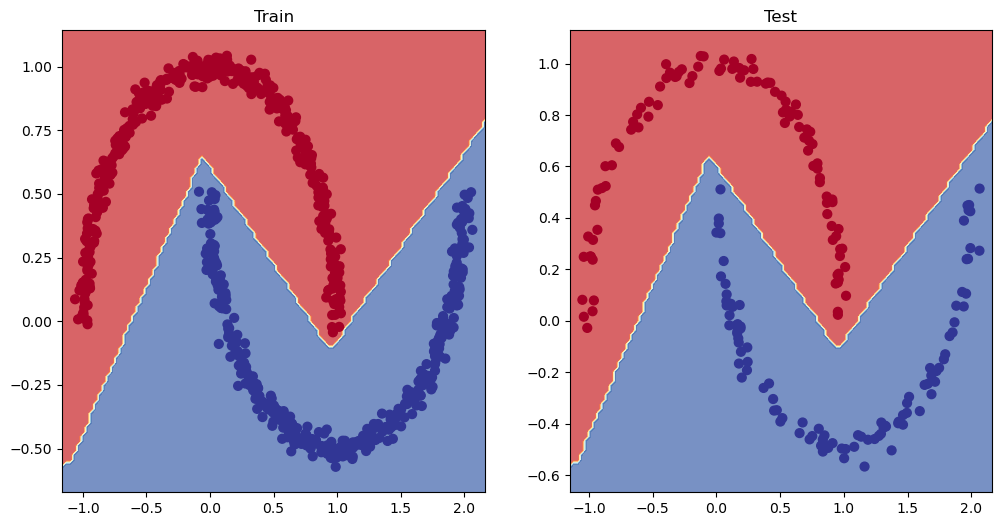

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

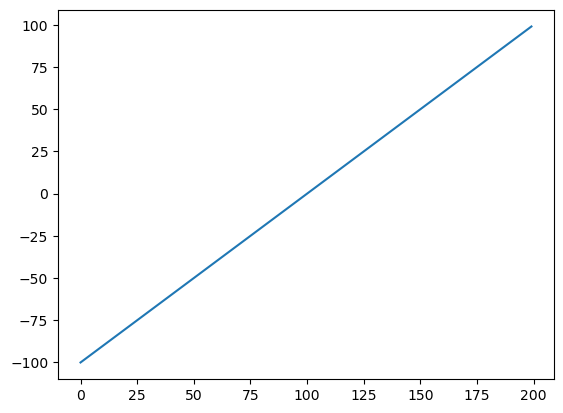

In [30]:
tensor_A = torch.arange(-100, 100, 1)
plt.plot(tensor_A)

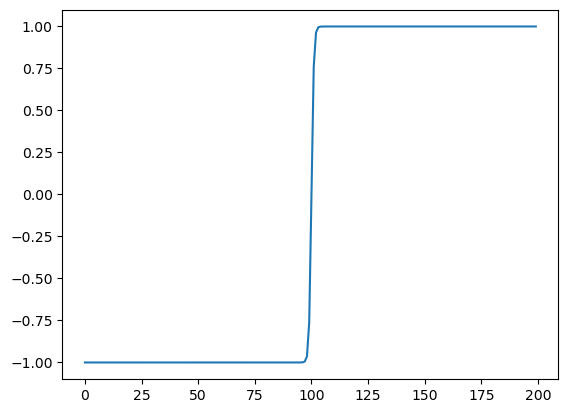

In [31]:
plt.plot(torch.tanh(tensor_A))

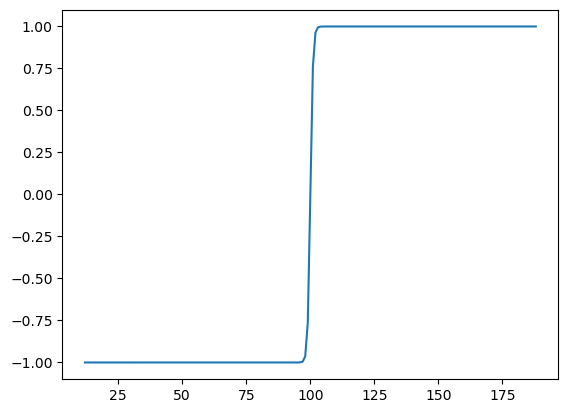

In [32]:
def tanh(x):
    y = (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))
    return y

plt.plot(tanh(tensor_A))

### Multi-class

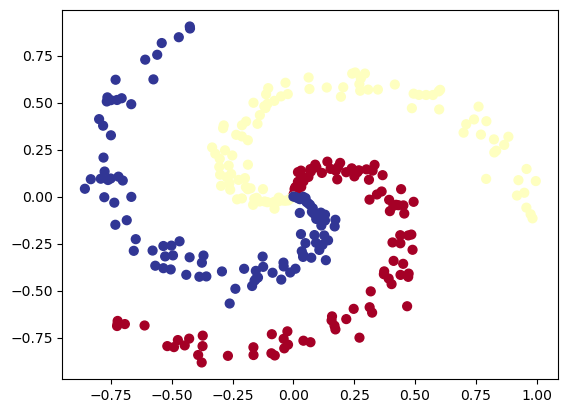

In [36]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [50]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

TypeError: expected np.ndarray (got Tensor)

In [51]:
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device)
acc_fn

MulticlassAccuracy()

In [52]:
class SpiralModel(nn.Module):
    def __init__(self, input_dim = 2, hidden_units = 10, output_dim = 3):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_dim)
        )
    
    def forward(self, x):
        y = self.linear_relu_stack(x)
        return y
    
model_1 = SpiralModel().to(device)
print(model_1)

SpiralModel(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)


In [53]:
# Setup data to be device agnostic
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)
# Print out first 10 untrained model outputs (forward pass)
print("Logits:")
## Your code here ##
print(model_1(X_train)[:10])
print("Pred probs:")
## Your code here ##
print(torch.softmax(model_1(X_train)[:10], dim=1))
print("Pred labels:")
## Your code here ##
print(torch.argmax(torch.softmax(model_1(X_train)[:10], dim=1), dim=1))

torch.float32 torch.float32 torch.int64 torch.int64
Logits:
tensor([[ 0.2319,  0.2539, -0.3131],
        [ 0.2314,  0.2585, -0.3182],
        [ 0.2334,  0.2621, -0.3210],
        [ 0.2029,  0.3848, -0.3723],
        [ 0.2129,  0.3605, -0.3651],
        [ 0.2263,  0.3047, -0.3384],
        [ 0.2301,  0.2886, -0.3330],
        [ 0.2321,  0.2271, -0.3037],
        [ 0.2233,  0.3004, -0.3359],
        [ 0.2032,  0.3855, -0.3730]], grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.3843, 0.3929, 0.2228],
        [0.3839, 0.3945, 0.2216],
        [0.3841, 0.3953, 0.2206],
        [0.3620, 0.4343, 0.2037],
        [0.3676, 0.4261, 0.2063],
        [0.3773, 0.4081, 0.2145],
        [0.3803, 0.4032, 0.2165],
        [0.3875, 0.3856, 0.2268],
        [0.3771, 0.4073, 0.2156],
        [0.3621, 0.4345, 0.2035]], grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1])


In [60]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.02)

In [62]:
epochs = 1000

for epoch in range(epochs):
    model_1.train()
    
    logits_train = model_1(X_train)
    probs_train = torch.softmax(logits_train, dim=1)
    preds_train = torch.argmax(probs_train, dim=1)
    
    loss = loss_func(logits_train, y_train)
    acc = acc_fn(preds_train, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_1.eval()
    with torch.inference_mode():
        logits_test = model_1(X_test)
        probs_test = torch.softmax(logits_test, dim=1)
        preds_test = torch.argmax(probs_test, dim=1)
        
        loss_test = loss_func(logits_test, y_test)
        acc_test = acc_fn(preds_test, y_test)
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, acc: {acc:.2f} | Test loss: {test_loss:.5f}, acc: {acc_test:.2f}")

Epoch: 0 | Train loss: 0.06207, acc: 0.99 | Test loss: 0.01437, acc: 1.00
Epoch: 100 | Train loss: 0.06162, acc: 0.99 | Test loss: 0.01437, acc: 1.00
Epoch: 200 | Train loss: 0.06118, acc: 0.99 | Test loss: 0.01437, acc: 1.00
Epoch: 300 | Train loss: 0.06075, acc: 0.99 | Test loss: 0.01437, acc: 1.00
Epoch: 400 | Train loss: 0.06033, acc: 0.99 | Test loss: 0.01437, acc: 1.00
Epoch: 500 | Train loss: 0.05993, acc: 0.99 | Test loss: 0.01437, acc: 1.00
Epoch: 600 | Train loss: 0.05954, acc: 0.99 | Test loss: 0.01437, acc: 1.00
Epoch: 700 | Train loss: 0.05916, acc: 0.99 | Test loss: 0.01437, acc: 1.00
Epoch: 800 | Train loss: 0.05879, acc: 0.99 | Test loss: 0.01437, acc: 1.00
Epoch: 900 | Train loss: 0.05843, acc: 0.99 | Test loss: 0.01437, acc: 1.00


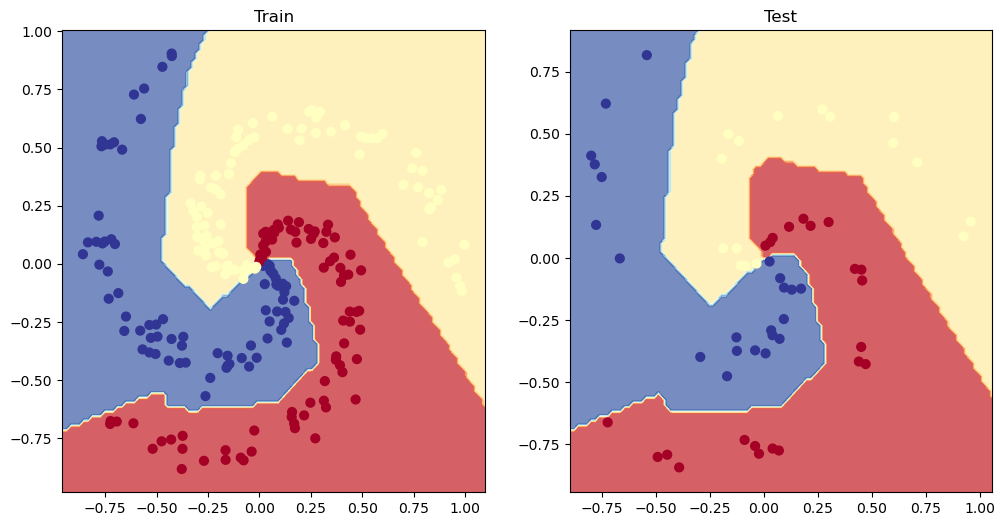

In [63]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)